In [15]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time

In [16]:
rootfolder = ".."

Useful function for plot the 2D DCT dictionary

In [17]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn * p + bound * (nnn - 1), nnn * p + bound * (nnn - 1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i - m) / nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m : m + p, n : n + p] = atom

    return img

Define a function that implements the OMP

In [18]:
def OMP(s, D, L, tau):
    M, N = D.shape
    x = np.zeros(N)
    
    # residual
    r =  s - (D @ x)
    
    # support set
    omega = []
    
    while np.linalg.norm(r) > tau and np.count_nonzero(x) < L:

        # SWEEP STEP: look for the column of D that matches at best noisySignal
        # compute the residual w.r.t. each column of D
        e = np.zeros(N)
        for j in range(N):
            dj = D[:,j]
            zj = ((r.T @ dj) / np.linalg.norm(dj))**2
            e[j] = np.linalg.norm(r)**2 - zj

        # find the column of D that matches at best r
        jStar = np.argmin(e)

        # UPDATE the support set with the jStar coefficient
        omega.append(jStar)
        # this makes sense but it makes the graph soften the spikes because it's not using all the points
        # if jStar not in omega: # because omega is a set
        #     omega.append(jStar) # this also guarantees to obtain a singular matrix

        # update the coefficients by solving the least square problem min ||D_omega x - s ||
        D_omega = D[:,omega]
        l_term = np.linalg.inv(D_omega.T @ D_omega)
        r_term = D_omega.T @ s
        x_omega = l_term @ r_term

        x[omega] = x_omega

        # update the residual
        r = s - (D @ x)

    return x

Load the image and rescale it in $[0,1]$

In [19]:
img = imread(f"{rootfolder}/data/peppers256.png") / 255
# img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p**2

Corrupt the image with white gaussian noise

In [20]:
sigma_noise = 20 / 255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Percentage of removed pixel

In [21]:
perc_of_removed_pixels = 0.25

Arbitrarily remove pixels setting them to zero

In [22]:
# create a vector with all the indexes of the image
idx = np.arange(img.size)

# shuffle it and take the target percentage of indexes
np.random.shuffle(idx)
removed = int(perc_of_removed_pixels * img.size)
idx = idx[:removed]

# the mask is 0 for the chosen idx, 1 elsewhere
msk = np.ones_like(img).astype(int)
msk.ravel()[idx] = 0

# apply the mask: set to 0 some elements in the noisy image
noisy_img = noisy_img * msk

In [23]:
np.unique(msk, return_counts=True)

(array([0, 1]), array([16384, 49152]))

In [24]:
msk[1, 1]

np.int64(1)

In [25]:
noisy_img[1, 1]

np.float64(0.5649173564679126)

Compute the psnr of the noisy input

In [26]:
mse = np.mean((img - noisy_img) ** 2)
psnr_noisy = 10 * np.log10(1 / mse)
psnr_noisy

np.float64(11.286890857592928)

Text(0.5, 1.0, 'Dead pixels')

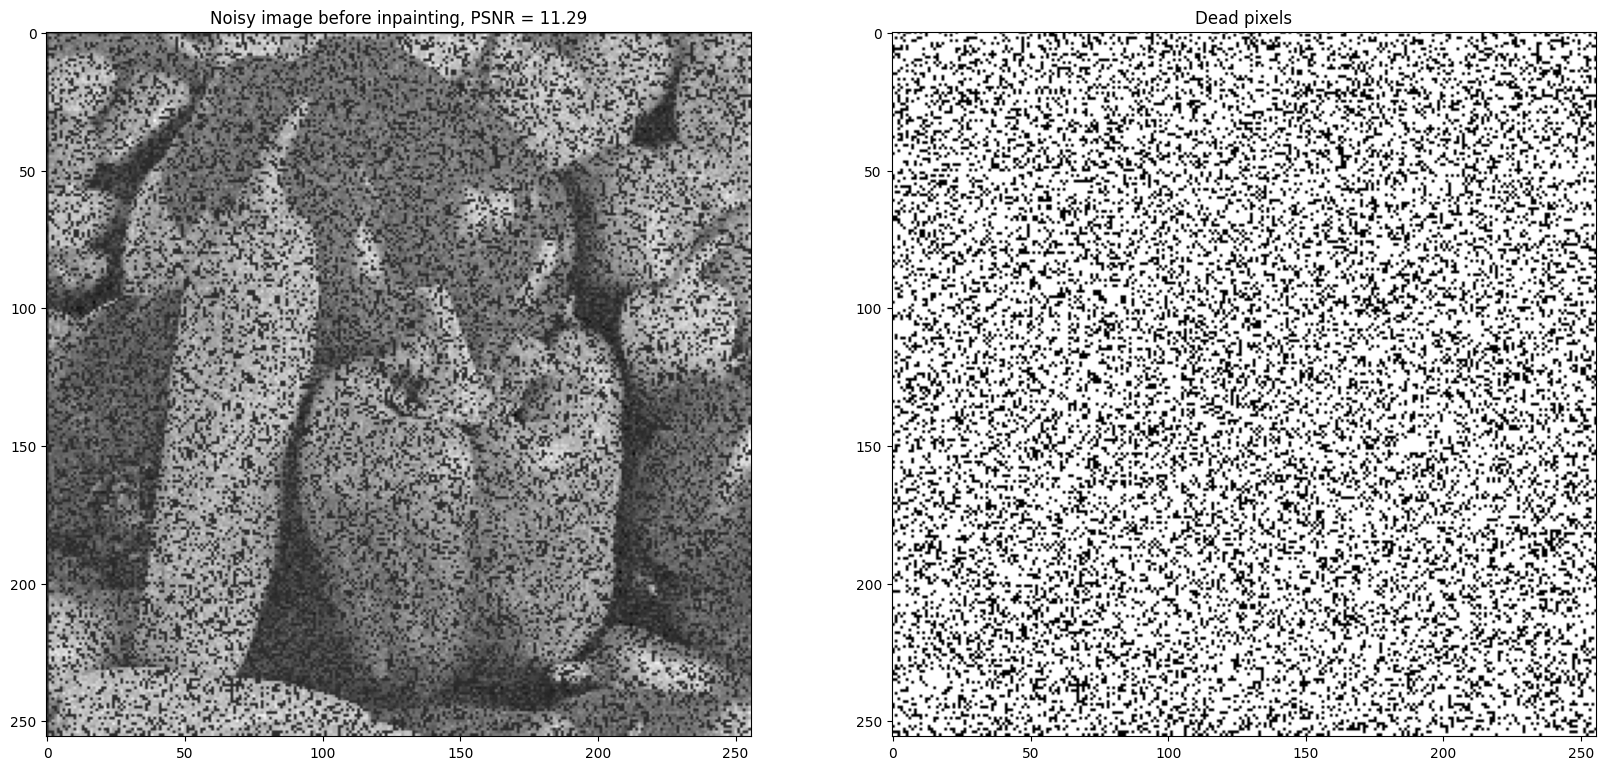

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(noisy_img, cmap="gray")
ax[0].set_title(f"Noisy image before inpainting, PSNR = {psnr_noisy:.2f}")

ax[1].imshow(msk, cmap="gray")
ax[1].set_title(f"Dead pixels")

Load and display the dictionary learned from patches

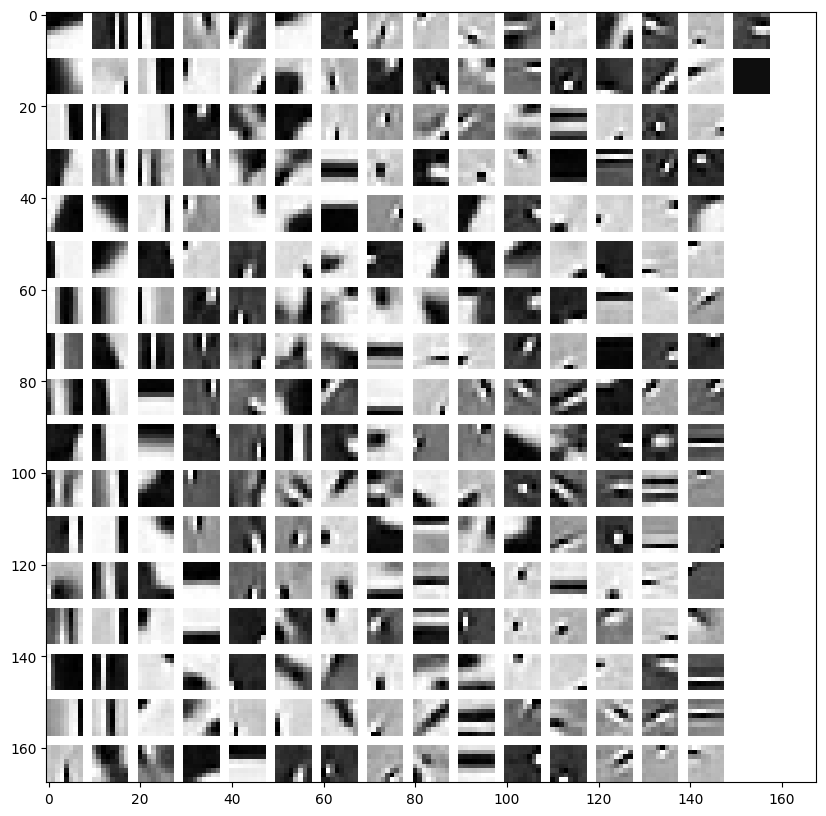

In [31]:
D = loadmat(f"{rootfolder}/data/dict_nat_img.mat")["D"]

# add a constant atom to D, KSVD was trained over patches with zero mean - and normalize it
# UPDATE D
D = np.concatenate((D, np.ones((D.shape[0], 1))), axis=1)

# Normalize the dictionary 
D = D / np.linalg.norm(D)

# fill the dictionary with ones and divide by the norm is the same as adding back the mean atom 
# (removed at ksvd)   D = D - D.mean(axis=0) 


# display the dictionary
D_img = get_dictionary_img(D)

plt.figure(figsize=(10, 10))
plt.imshow(D_img, cmap="gray")

Inpainting
----------


In [32]:
# SET stopping criteria of OMP
# orthogonal matching pursuit uses sparsity and errors as stopping criteria
L = M / 2

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# define the step (=p for non overlapping paches)
STEP = 1  # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [33]:
time_start = time.time()
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p].reshape(-1)

        # patch extracted from the mask
        m = msk[i:i+p, j:j+p].reshape(-1)

        # design the projection operator over the current patch
        proj = np.diag(m) # creates a diagonal matrix with all the elements of m (since m is a vector (64,))

        # tau should be proportional to the number of pixels remaining in the patch
        tau = 1.156 * np.sqrt(np.count_nonzero(s)) * sigma_noise # needs to be multiply by sigma_noise, otherwise it's too high

        # sparse coding w.r.t. PD the inpainted dictionary using L and tau as stopping criteria
        PsD = proj @ D
        x = OMP(s, PsD, L, tau)

        # reconstruction: synthesis w.r.t. D the dictionary yielding sparse representation
        s_hat = D @ x

        # use uniform weights for aggregation
        w = 1

        # put the denoised patch into the estimated image using uniform weights
        # UPDATE img_hat
        img_hat[i:i+p, j:j+p] += s_hat.reshape((p, p)) * w

        # store the weight of the current patch in the weight matrix
        # UPDATE weights
        weights[i:i+p, j:j+p] += w
time_end = time.time()
print(f'{time_end - time_start:.0f} seconds running')

529 seconds running


Normalize the estimated image with the computed weights

In [34]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 29.79')

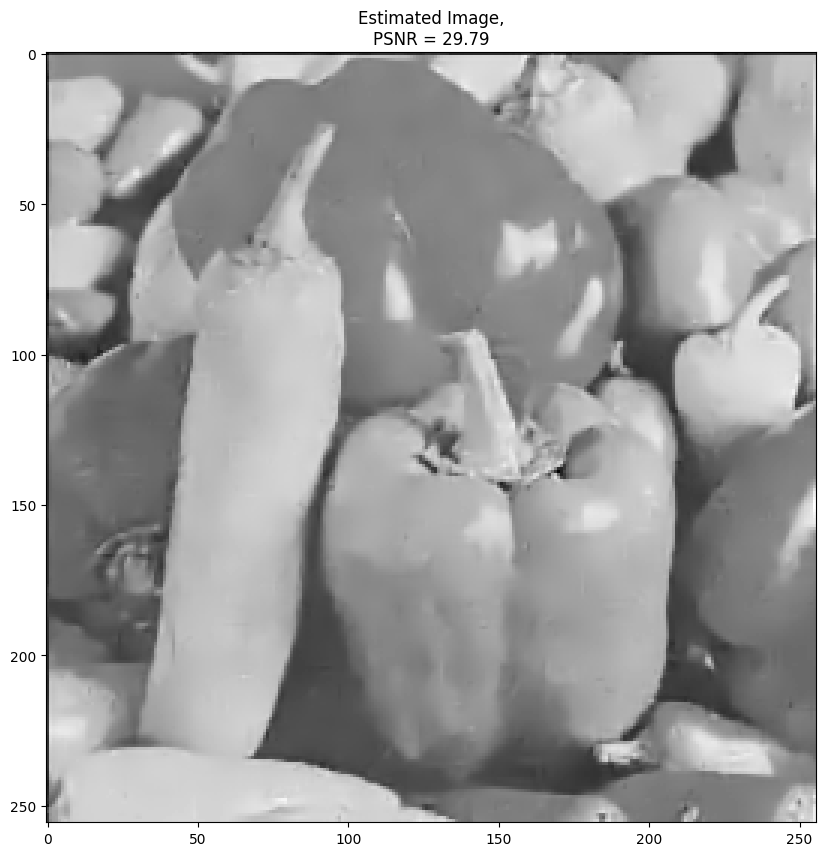

In [35]:
mse = np.mean((img - img_hat) ** 2)
psnr_hat = 10 * np.log10(1 / mse)

plt.figure(figsize=(10, 10))
plt.imshow(img_hat, cmap="gray")
plt.title(f"Estimated Image,\nPSNR = {psnr_hat:.2f}")